## Importieren der  deep learning-Bibliotheken und Funktionen

In [75]:
import tensorflow as tf # Deep Learning-Bibliothek
import os  # os ist ein Modul in Python um das Datei, durch das Dateisystem zu navigieren
# die Dateien enthaltenen Verzeichnissen in Dataframe auszudrucken
import glob   
import pandas as pd

import numpy as np 
import matplotlib.pyplot as plt # Image Visualation
# Deep learning-keras Funktionen 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout # deep learning CNN Layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy
import cv2 # Bild einlesen


print(tf.__version__)

2.15.0


## Die verfügbare Device in PC

In [76]:
cpus = tf.config.experimental.list_physical_devices('CPU')
cpus

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

## Importieren, Auslesen der train-Daten und in Dataframe-Struktur ausdrucken

In [77]:
data_dir = 'data'

filepaths = glob.glob(os.path.join(data_dir, '*', '*')) # für jedes Bild in beiden Klassen
labels = [os.path.basename(os.path.dirname(fp)) for fp in filepaths]

train_df = pd.DataFrame({'filepaths': filepaths, 'labels': labels})
for image_class in os.listdir(data_dir):  # Die Klassen in data files
    print(image_class)

Benign cancer
cancer


In [78]:
train_df

,filepaths,labels
0,data\Benign cancer\ISIC_0000000.jpg,Benign cancer
1,data\Benign cancer\ISIC_0000001.jpg,Benign cancer
2,data\Benign cancer\ISIC_0000003.jpg,Benign cancer
3,data\Benign cancer\ISIC_0000006.jpg,Benign cancer
4,data\Benign cancer\ISIC_0000007.jpg,Benign cancer
...,...,...
1086,data\cancer\ISIC_0055342.jpg,cancer
1087,data\cancer\ISIC_0055352.jpg,cancer
1088,data\cancer\ISIC_0055650.jpg,cancer
1089,data\cancer\ISIC_0056264.jpg,cancer


## Laden von Bilddaten in keras

In [79]:
tf.keras.utils.image_dataset_from_directory 

<function keras.src.utils.image_dataset.image_dataset_from_directory(directory, labels='inferred', label_mode='int', class_names=None, color_mode='rgb', batch_size=32, image_size=(256, 256), shuffle=True, seed=None, validation_split=None, subset=None, interpolation='bilinear', follow_links=False, crop_to_aspect_ratio=False, **kwargs)>

In [80]:
# um ein Tensorflow-keras-Dataset aus Bildern in 'data' zu erstellen
data = tf.keras.utils.image_dataset_from_directory('data',image_size=(256,256))

Found 1091 files belonging to 2 classes.


In [81]:
# der Datensatz in einen Numpy-Iterator umwandeln. Das ermöglicht den Zugriff auf die Batches von Bildern im Dataset.
data_iterator = data.as_numpy_iterator() 

In [82]:
batch = data_iterator.next() #  das erste Element des Iterator abgerufen

In [83]:
# Bilder als numpy array, 32 Bildern mit der Größe 256x256 in RGB-mode
batch[0].shape

(32, 256, 256, 3)

In [84]:
# Lable von der Batch anzeigen
batch[1]

array([0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1,
       1, 0, 1, 0, 0, 0, 1, 1, 1, 0])

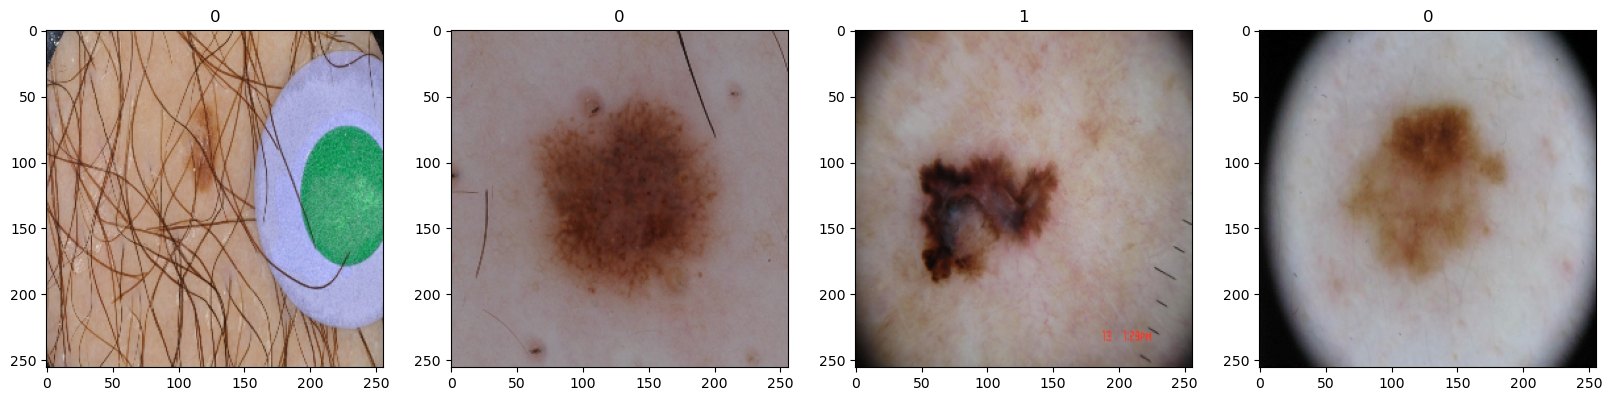

In [85]:
# Anzeigen ein Batch von Iterator des Traingsdaten
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

## Normalisierung der Pixelwerte auf den Bereich zwischen 0 und 1.

In [86]:
data = data.map(lambda x,y: (x/255, y)) # jedes EingabeBild 'x' wird durch 255 geteilt

In [87]:
# der Datensatz in einen Numpy-Iterator und mit .next() wird das erste Element des Iterator abgerufen
data.as_numpy_iterator().next()

(array([[[[0.8098039 , 0.7235294 , 0.672549  ],
          [0.80784315, 0.7372549 , 0.68235296],
          [0.7941176 , 0.74313724, 0.68039215],
          ...,
          [0.77254903, 0.7019608 , 0.62352943],
          [0.7745098 , 0.70392156, 0.6254902 ],
          [0.75686276, 0.6862745 , 0.60784316]],
 
         [[0.8235294 , 0.7176471 , 0.6509804 ],
          [0.8352941 , 0.73333335, 0.6666667 ],
          [0.8235294 , 0.73333335, 0.6627451 ],
          ...,
          [0.8039216 , 0.69803923, 0.627451  ],
          [0.7745098 , 0.66862744, 0.6019608 ],
          [0.78039217, 0.6745098 , 0.60784316]],
 
         [[0.8333333 , 0.72745097, 0.6607843 ],
          [0.82941175, 0.7235294 , 0.65686274],
          [0.8372549 , 0.72745097, 0.6627451 ],
          ...,
          [0.77843136, 0.65686274, 0.57843137],
          [0.76666665, 0.64509803, 0.56666666],
          [0.80588233, 0.6843137 , 0.60588235]],
 
         ...,
 
         [[0.80196077, 0.6882353 , 0.65686274],
          [0.79607

## teilen den gesamten Datensatz in Trainingsdaten (70%), Validierungsdaten (20%) und Testdaten (10%) auf

In [88]:
print(len(data)) # Anzahl der Batches, in denen 32 Bildern gibt, 35x32 = 1120 ca in 'dataset'
train_size = int(len(data)*.7) # 70% der Gesamtdatensätze, um das deep learning modell zu trainieren
val_size = int(len(data)*.2)+1 # 20% ,während ds Trainingsprozess das modell zu bewerten
test_size = int(len(data)*.1)  # 10%, um die tatsächliche Leistung des Modells zu bewerten, nachdem es trainiert wurde.

35


In [89]:
train_size+val_size+test_size # anpassen der Aufteilung des Gesamteanzahl des Datensatzes

35

In [90]:
# Abdeckung den Gesamtenanzahl des Datensatzes durch den obigen Aufteilung
train = data.take(train_size) # take() für den Auswahl
val = data.skip(train_size).take(val_size) # skip() für den Überspringen
test = data.skip(train_size+val_size).take(test_size)

## Erstellung von CNN-Algorithmus

In [91]:
train

<_TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [92]:
model = Sequential()  # ist ein Klass,um die Schichten des CNNS nacheinander hinzugefügt werden.

In [93]:
# 1. Hier sind 3 Faltungsschichten mit 3 MaxPolling-Layers
# 1.1 Das erste Faltungsschicht mit 16 Filter-Matrix mit Größe (3x3) und Schrittweise von 1
# Die Aktivierungsfunktion ist ReLU un mit Eingabebildgröße von 256x256 in RGB-mode
model.add(Conv2D(256, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())  # MaxPooling schicht nach dem ReLU-Funktion
model.add(Dropout(0.4)) # Überanpassung zu reduzieren, Ohne das Dropout wird das Training zu schnell und lernt schlecht
# 1.2 Hier wird die Anzahl der Filter-Matrixen erhöht
model.add(Conv2D(128, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Dropout(0.4))
# 1.3 Weitere Erhöhung von der Anzahl der Filter-Matrixen
model.add(Conv2D(64, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
# 2. Flattening-Schicht, um die 3D-Ausgabe von letzte Faltungsschicht in einen Vektor für die Dense-Schichten umzuwandeln.
model.add(Flatten())
# 3. Vollvernetzte Schicht Dense mit 32 Neuronen mit ReLU-Funktion
model.add(Dense(32, activation='relu'))
# 4. Vollvernetzte Schicht Dense mit 1 Neuron, das die Ausgabe liefert.
#  Sigmoid- Funktion, weil es sich um eine binäre Klassifikation handelt
model.add(Dense(1, activation='sigmoid'))

In [94]:
# Kompilieren des CNNS-Algorithmus mit Adam-Optimizer für Binäre Klassifikation
# Verlustfunktion als BinaryCrossentropy und als Metrik wird die Genauigkeit 'accuracy' verwendet.

optimizer = Adam(learning_rate=0.0001) 
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])


In [95]:
#  die Architektur, die Anzahl der Parameter und mehr anzeigt.
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 254, 254, 256)     7168      
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 127, 127, 256)     0         
 g2D)                                                            
                                                                 
 dropout_3 (Dropout)         (None, 127, 127, 256)     0         
                                                                 
 conv2d_4 (Conv2D)           (None, 125, 125, 128)     295040    
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 62, 62, 128)       0         
 g2D)                                                            
                                                                 
 dropout_4 (Dropout)         (None, 62, 62, 128)      

## Trainieren des Modelles

In [96]:
# logs-Datei
logdir = 'logs'

In [97]:
# Um das Modell zu speichern und das Training zu überwachen.
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [98]:
# Training des Modelles mit 50 epochs und die Auswertung des Modelles von 'val-data'
# epochs beschreibt wie lange das Training dauert und ist ein Durchlauf in den gesamten Trainingsdatateil
hist = model.fit(train, epochs=50, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/50
24/24 [==============================] - 155s 6s/step - loss: 0.6919 - accuracy: 0.5378 - val_loss: 0.6792 - val_accuracy: 0.5352
Epoch 2/50
24/24 [==============================] - 145s 6s/step - loss: 0.6383 - accuracy: 0.6341 - val_loss: 0.6174 - val_accuracy: 0.8477
Epoch 3/50
24/24 [==============================] - 143s 6s/step - loss: 0.4889 - accuracy: 0.7799 - val_loss: 0.4651 - val_accuracy: 0.8398
Epoch 4/50
24/24 [==============================] - 142s 6s/step - loss: 0.4140 - accuracy: 0.8125 - val_loss: 0.4508 - val_accuracy: 0.8516
Epoch 5/50
24/24 [==============================] - 140s 6s/step - loss: 0.4048 - accuracy: 0.8164 - val_loss: 0.4582 - val_accuracy: 0.8008
Epoch 6/50
24/24 [==============================] - 143s 6s/step - loss: 0.3693 - accuracy: 0.8490 - val_loss: 0.3842 - val_accuracy: 0.8945
Epoch 7/50
24/24 [==============================] - 147s 6s/step - loss: 0.3481 - accuracy: 0.8542 - val_loss: 0.4246 - val_accuracy: 0.8477
Epoch 8/50
24

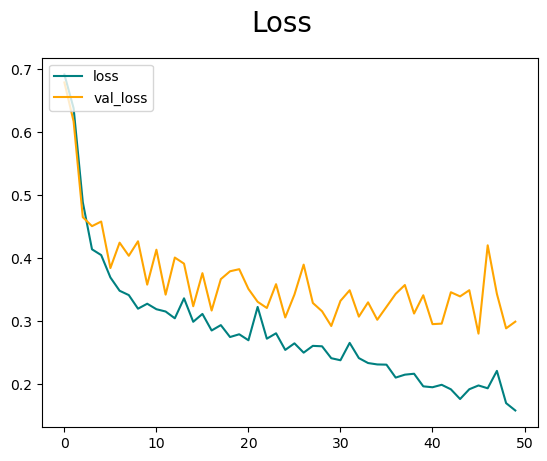

In [99]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

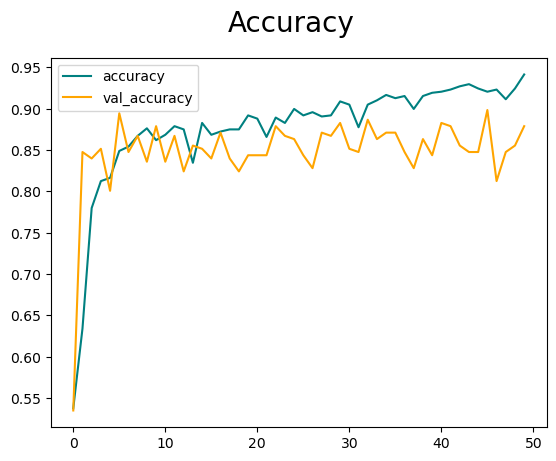

In [100]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

##  Evaluations des Modelles

In [101]:
# Initialisieren der Metrikenobjekte:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [102]:
# Iterieren über den Testdatensatz, um das Modell zu berechnen:
for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 [==============================] - 0s 217ms/step


In [103]:
print(f'Precision: {pre.result().numpy()}, Recall: {re.result().numpy()}, BinaryAccuracy: {acc.result().numpy()}')


Precision: 0.8709677457809448, Recall: 0.8709677457809448, BinaryAccuracy: 0.8805969953536987


## Test

(1519, 1818, 3)


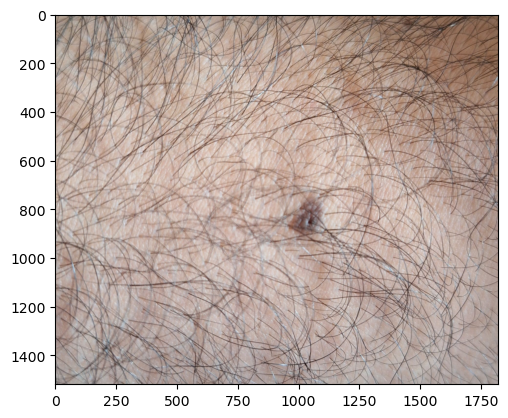

In [116]:
# Ein Hautkrebs Bild von Broswer herunterladen, um das Test durchzuführen
img = cv2.imread('test4.jpg') 
print(img.shape) # Hier im Orginalen Größe
plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB)) # zu RGB-mode umzuwanden
plt.show()

(256, 256, 3)


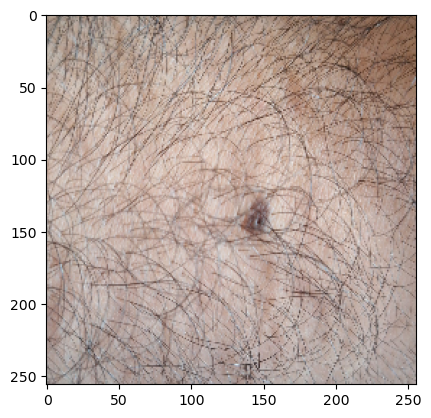

In [117]:
# zu RGB-mode umzuwanden
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# Dimensionen des Testsbildes reduzieren
resize_img = tf.image.resize(img, (256, 256)) # Skalierung
print(resize_img.shape) # Hier im reduzierte Größe
# Anzeigen des dimensionsreduziertes Bildes 
plt.imshow(resize_img.numpy().astype(int))
plt.show()

In [118]:
# Modellvorhersage für das vorverarbeitete Bild
yhat = model.predict(np.expand_dims(resize_img/255, 0))


1/1 [==============================] - 0s 237ms/step


In [119]:
yhat

array([[0.17858788]], dtype=float32)

In [120]:
# Ist eine Bedingung für die 2 möglichen Vorhersagen
if yhat > 0.5: 
    print(f'Dieses Haubild zeigt ein bösartiger Hautkrebs')
else:
    print(f'Dieses Haubild zeigt ein gutartiger Hautkrebs')



Dieses Haubild zeigt ein gutartiger Hautkrebs


## Modell Speichern

In [121]:
from tensorflow.keras.models import load_model

In [122]:
model.save(os.path.join('models','BinäreHautkrebsKlassifikation.h5'))